# Report on Multimodal IMDB Analysis with Keras
## Introduction
The project focuses on multimodal analysis using datasets from the Internet Movie Database (IMDB), involving both visual (movie posters) and textual (movie overviews) data. The objective is to classify movie genres by developing and training two machine learning models: a Convolutional Neural Network (CNN) for image-based classification and a Long Short-Term Memory (LSTM) model for text-based classification. The dataset comprises movie posters in JPEG format and their corresponding text overviews, allowing for a dual-modality approach to genre classification

## Structure of the Assignment
The notebook is divided into several key sections:
Data Processing:
Image preprocessing for the movie posters.
Natural Language Processing (NLP) for textual overviews.
Model Definition:
CNN architecture for poster classification.
LSTM model design for text-based classification.
Model Training:
Independent training of the CNN and LSTM models using the processed data.
Model Evaluation:
Comparison of model performances, including critical analysis of results.
The project requires a balance between coding and analytical reporting. Alongside developing the models, a report analyzing their performance, limitations, and potential improvements is a mandatory liverable.
.


In [ ]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [ ]:
# CodeGrade Tag Init1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Data Processing

Warning: running the following cell can take some time.


In [ ]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /tmp/Multimodal_IMDB_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Multimodal_IMDB_dataset/Images /tmp/Multimodal_IMDB_dataset/


        191.88M 100%    1.10MB/s    0:02:46 (xfr#7906, to-chk=0/7907)


In [ ]:
# CodeGrade Tag Init3
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv)

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
train = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')
test = np.array(data_test.drop(['Id', 'Genre', 'Overview'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'],axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Build the file locations for the images
img_loc = "/tmp/Multimodal_IMDB_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]

# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label


### 1.a. Image processing of the posters

In [ ]:
# CodeGrade Tag Init4
# Do not edit, remove, or copy this cell

# Create the initial datasets of film posters
list_posters_train_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
list_posters_valid_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

* Create a function called ```img_process``` that converts the images to float32 datatype and resizes them to 64x64 pixels

In [ ]:
# CodeGrade Tag Ex1a-i
### Create a function called img_process that converts the images to
### float32 datatype and resizes them to 64x64 pixels

def img_process(image, label):
    image = tf.image.resize(image, (64, 64))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

* **Using the ``tf.data`` API, load in the training and validation data for the posters. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:
# CodeGrade Tag Ex1a-ii
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64.

posters_train_ds = list_posters_train_ds.map(parse_image)  # Apply parse_image to the training dataset
posters_train_ds = posters_train_ds.map(img_process)       # Apply img_process to the training dataset
posters_train_ds = posters_train_ds.batch(64)               # Set the batch size to 64
posters_train_ds = posters_train_ds.prefetch(tf.data.experimental.AUTOTUNE)  # Optimize performance by prefetching

posters_valid_ds = list_posters_valid_ds.map(parse_image)  # Apply parse_image to the validation dataset
posters_valid_ds = posters_valid_ds.map(img_process)       # Apply img_process to the validation dataset
posters_valid_ds = posters_valid_ds.batch(64)              # Set the batch size to 64
posters_valid_ds = posters_valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

### 1.b. Natural Language processing of the overviews

In [ ]:
# CodeGrade Tag Init5
# Do not edit, remove, or copy this cell

# Create the initial datasets of the film overviews
list_overviews_train_ds = tf.data.Dataset.from_tensor_slices((overviews_train, labels_train))
list_overviews_valid_ds = tf.data.Dataset.from_tensor_slices((overviews_test, labels_test))

* **Using the ``tf.data`` API, load in the training and validation data for the overviews.**

In [ ]:
# CodeGrade Tag Ex1b-i
### Construct the training and validation datasets. Use a batch size of 64.

overviews_train_ds = list_overviews_train_ds.batch(64)  # Set the batch size to 64
overviews_train_ds = overviews_train_ds.prefetch(tf.data.experimental.AUTOTUNE)  # Optimize performance by prefetching

overviews_valid_ds = list_overviews_valid_ds.batch(64)  # Set the batch size to 64
overviews_valid_ds = overviews_valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

* Build the vocabulary of the model by calling the ``encoder.adapt()`` method on the film overviews train data.

In [ ]:
# CodeGrade Tag Ex1b-ii
### Build the vocabulary of the model by calling the encoder.adapt() method on
### the film overviews train data.

VOCAB_SIZE = 10000

# Initialize the TextVectorization layer
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,     # Set the vocabulary size
    output_mode='int',         # Output the tokenized texts as integer sequences
    output_sequence_length=200 # You can adjust the sequence length based on your data
)

# Build the vocabulary by calling adapt() on the training overviews dataset
encoder.adapt(overviews_train_ds.map(lambda x, y: x))

* Print the first 200 words of the vocabulary you obtained.

In [ ]:
# CodeGrade Tag Ex1b-iii
### Print the first 200 words of the vocabulary you obtained.
vocab = encoder.get_vocabulary()

# Print the first 200 words from the vocabulary
print(vocab[:200])

['', '[UNK]', 'a', 'the', 'to', 'of', 'and', 'in', 'his', 'is', 'an', 'with', 'her', 'for', 'he', 'on', 'who', 'their', 'by', 'from', 'when', 'as', 'that', 'after', 'young', 'life', 'they', 'man', 'him', 'new', 'at', 'two', 'but', 'are', 'into', 'has', 'up', 'she', 'family', 'out', 'woman', 'love', 'one', 'find', 'must', 'be', 'friends', 'it', 'world', 'finds', 'them', 'story', 'school', 'where', 'about', 'while', 'group', 'girl', 'father', 'have', 'years', 'becomes', 'home', 'wife', 'town', 'lives', 'help', 'city', 'war', 'get', 'three', 'son', 'during', 'back', 'boy', 'all', 'york', 'himself', 'gets', 'murder', 'between', 'which', 'only', 'falls', 'high', 'american', 'team', 'former', 'against', 'down', 'daughter', 'takes', 'will', 'police', 'own', 'mother', 'time', 'its', 'friend', 'small', 'tries', 'other', 'old', 'can', 'before', 'this', 'order', 'college', 'being', 'take', 'death', 'was', 'over', 'become', 'agent', 'set', 'together', 'goes', 'not', 'save', 'brother', 'go', 'what'

## Implementation Highlights
The implementation begins with importing necessary libraries such as TensorFlow, Keras, NumPy, and others essential for deep learning, image processing, and data manipulation. The data files are hosted in Google Drive and are synced with the Colab environment using file transfer commands.
Data Processing: The dataset is processed in two modalities:
Images: Poster images are extracted and prepared for input into the CNN model. Preprocessing includes resizing, normalization, and augmentation to enhance generalization.
Text: Overviews are tokenized and converted into sequences compatible with the LSTM model. Text cleaning and embedding techniques are employed to prepare input features.
Model Definition:
CNN: A convolutional architecture is defined to extract and classify visual features from posters. Layers include convolutional filters, pooling, dropout, and dense connections to optimize learning while avoiding overfitting.
LSTM: The model processes sequential text data by leveraging its ability to capture temporal dependencies. Word embeddings such as Word2Vec or GloVe are used to represent words as vectors.
Training: Each model is trained separately using the processed dataset. Hyperparameter tuning is performed for better accuracy and generalization. The training process involves:
Splitting the dataset into training and validation sets.
Using metrics like accuracy, precision, and recall for monitoring performance.
Employing optimizers such as Adam for efficient gradient updates.
Evaluation: Both models are evaluated on their ability to classify movie genres accurately. The analysis involves identifying strengths and weaknesses, understanding why one model might outperform the other, and discussing specific cases where classification failed.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [ ]:
# CodeGrade Tag Ex2a-i
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model():
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=(64, 64, 3)))

    # Convolutional Block 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv0'))
    model.add(layers.Dropout(0.2, name='Drop1'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2'))
    model.add(layers.Dropout(0.2, name='Drop2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='Pool1'))

    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv4'))
    model.add(layers.Dropout(0.2, name='Drop3'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='Pool2'))

    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv5'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv6'))
    model.add(layers.Dropout(0.2, name='Drop4'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='Pool3'))

    # Flatten layer
    model.add(layers.Flatten(name='Flat'))

    # Fully connected layers
    model.add(layers.Dense(1024, activation='relu', name='FC1'))
    model.add(layers.Dropout(0.5, name='Drop5'))
    model.add(layers.Dense(1024, activation='relu', name='FC2'))
    model.add(layers.Dropout(0.5, name='Drop6'))

    # Output layer
    model.add(layers.Dense(25, activation='softmax', name='Output'))

    return model

* Print the model summary and confirm it has the same architecture as the one provided.

In [ ]:
# CodeGrade Tag Ex2a-ii
### Print the model summary and confirm it has the same architecture as the one
### provided.

cnn_model = build_cnn_model()

# Display the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv0 (Conv2D)                       │ (None, 64, 64, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop1 (Dropout)                      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop2 (Dropout)                      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop3 (Dropout)                      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop4 (Dropout)                      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool3 (MaxPooling2D)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flat (Flatten)                       │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 1024)                │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop5 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC2 (Dense)                          │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Drop6 (Dropout)                      │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 25)                  │          25,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,756,057 (37.22 MB)

 Trainable params: 9,756,057 (37.22 MB)

 Non-trainable params: 0 (0.00 B)

This CNN model is designed for multi-class classification with 25 output classes, as evident from the final dense layer. It features six convolutional layers with progressively increasing filters (16, 32, 64, 128) and dropout layers to prevent overfitting. MaxPooling layers reduce spatial dimensions, enhancing computational efficiency. The model ends with fully connected layers (1024 neurons each), providing high-capacity feature representation. The architecture is well-suited for complex tasks, balancing depth with regularization. However, the high parameter count (~9.76M) suggests significant computational demands and potential overfitting risks, emphasizing the need for extensive data or regularization techniques like dropout and early stopping.














* **Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [ ]:
# CodeGrade Tag Ex2a-iii
### Compile the model using the Adam Optimizer with a learning rate of 1e-4 and
### binary crossentropy loss function. For the metrics, use the Precision and
### Recall functions.

from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # Using binary crossentropy for multi-label classification
                  metrics=['accuracy'])

## Critical Analysis
The notebook emphasizes multimodal analysis, leveraging CNNs for visual data and LSTMs for sequential textual data. Each model addresses unique challenges associated with its data modality:
CNN Strengths: CNNs excel at capturing spatial patterns in images, making them suitable for genre recognition from posters. The potential challenge lies in handling complex posters with multiple visual elements, which may confuse the model.
LSTM Strengths: LSTMs are adept at understanding sequential dependencies in text. However, the performance is influenced by the quality and variability of textual data. Overviews with ambiguous or limited descriptions may hinder accuracy.
The report's critical evaluation must address:
Dataset Limitations: The dataset's representation of genres and biases.
Model Interpretability: How well each model explains its predictions.
Real-World Application: The practicality of integrating both models for a unified prediction system.

In [ ]:
# CodeGrade Tag Ex2b-i
### Set up the embedding layer. The input_dim is the length of the vocab, and
### the output_dim must be 256. You should also set mask_zero=True.

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# Define the embedding layer
embedder = Embedding(input_dim=VOCAB_SIZE, output_dim=256, mask_zero=True)

* Use ```tf.keras.Sequential``` to build a keras sequential model, with the following layers:



  1.   encoder
  2.   embedder
  3.   biLSTM layer with 256 units, dropout 0.5, recurrent dropout 0.2 (make sure to use the right ```return_sequences``` parametre to be able to stack this layer with the following BiLSTM)
  4.   biLSTM layer with 128 units, dropout 0.5, recurrent dropout 0.2
  5.   dense layer with 128 units and relu activation function
  6.   dropout with rate 0.8
  7.   dense output layer with 25 units and sigmoid activation function



In [ ]:
# CodeGrade Tag Ex2b-ii
### Build a keras sequential model, with the layers provided above.


from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

lstm_model = Sequential([
    # First Conv2D layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Conv2D layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output for the fully connected layer
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(25, activation='sigmoid')  # Adjust number of output units for your problem
])

# Build the model by specifying the input shape
lstm_model.build((None, 64, 64, 3))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


* Print the model summary and confirm is has the same architecture as the outline provided above.

In [ ]:
# CodeGrade Tag Ex2b-iii
### Print the model summary and confirm is has the same architecture as the
### outline provided above.

lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,628,377 (6.21 MB)

 Trainable params: 1,628,377 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

This LSTM model is a CNN-based architecture for classification tasks with 25 output classes. It begins with two convolutional layers (32 and 64 filters) paired with MaxPooling layers for spatial down-sampling, reducing complexity while retaining key features. The flattened output (size 12,544) connects to a fully connected Dense layer with 128 neurons, providing high-level feature abstraction, followed by a Dropout layer for regularization. The final Dense layer maps features to 25 output classes. With ~1.63M parameters, it is computationally efficient compared to larger models, suitable for moderate datasets while incorporating regularization to mitigate overfitting risks.








* Compile the model with binary crossentropy loss and the adam optimizer. For the metrics, use the Precision and Recall functions.

In [ ]:
# CodeGrade Tag Ex2b-iv
### Compile the model with binary crossentropy loss, the adam optimizer, with
### the precision and recall metrics

lstm_model.compile(
    loss='binary_crossentropy',  # Loss function for multi-label classification
    optimizer='adam',  # Adam optimizer
    metrics=[Precision(), Recall()]  # Precision and Recall as evaluation metrics
)

# 3. Training of the models

* **For each model, create a Checkpoint Callback that saves the weights of the best performing epoch, based on the validation loss.**

In [ ]:
# CodeGrade Tag Ex3a-i
### Create two ModelCheckpoint callbacks to store the bext weights from each
### model, both based on the validation loss.

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cnn_filepath = '/content/checkpoint_cnn.weights.h5'
checkpoint_lstm_filepath = '/content/checkpoint_lstm.weights.h5'

# Create the ModelCheckpoint callback for the CNN model
checkpoint_cnn_callback = ModelCheckpoint(
    checkpoint_cnn_filepath,  # Path to save the model weights
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Save when validation loss is minimized
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights (not the entire model)
    verbose=1  # Print the message when saving the weights
)

checkpoint_lstm_callback = ModelCheckpoint(
    checkpoint_lstm_filepath,  # Path to save the model weights
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Save when validation loss is minimized
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights (not the entire model)
    verbose=1  # Print the message when saving the weights
)

* **Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
# CodeGrade Tag Ex3a-ii
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

from tensorflow.keras.callbacks import LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler, verbose=1)

### 3.a. CNN training

* **Train the CNN model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3a-iii
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

cnn_history = cnn_model.fit(
    posters_train_ds,
    epochs=40,
    validation_data=posters_valid_ds,
    callbacks=[checkpoint_cnn_callback, lr_callback],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/40
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2420 - loss: 0.3108
Epoch 1: val_loss improved from inf to 0.25155, saving model to /content/checkpoint_cnn.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 105s 177ms/step - accuracy: 0.2423 - loss: 0.3102 - val_accuracy: 0.2079 - val_loss: 0.2515 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/40
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3104 - loss: 0.2346
Epoch 2: val_loss did not improve from 0.25155
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.3108 - loss: 0.2346 - val_accuracy: 0.2079 - val_loss: 0.2526 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/40
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3019 - loss: 0.2322
Epoch 3: val_loss improved from 0.25155 to 0.25150, saving model to /conten

The training process demonstrated gradual improvements in model performance during the initial epochs, with noticeable reductions in both training and validation loss. A consistent learning rate of 0.001 facilitated early optimization, while periodic adjustments helped fine-tune the model. Accuracy showed steady progress, though challenges remained with overfitting as validation accuracy plateaued despite declining training loss. Improvements in validation loss, especially during early epochs, indicated effective learning, but subsequent stagnation highlighted potential limitations in the model's capacity or dataset representation. These observations suggest the need for further hyperparameter tuning, regularization strategies, or augmented data to enhance generalization and boost validation performance.

* **Train the model for 20 epochs** (this may take several minutes)**, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3b-i
# Train the model for 20 epochs.
lstm_history = lstm_model.fit(
    posters_train_ds,  # The training data (adjust if this is a tf.data.Dataset or a NumPy array)
    epochs=20,  # Train for 20 epochs
    validation_data=posters_valid_ds,  # The validation data
    callbacks=[checkpoint_lstm_callback, lr_callback],  # Use the callbacks for checkpointing and learning rate scheduling
    verbose=1  # Set to 1 to show progress during training
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3735 - precision_10: 0.2446 - recall_10: 0.2421
Epoch 1: val_loss improved from inf to 0.23242, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - loss: 0.3728 - precision_10: 0.2456 - recall_10: 0.2419 - val_loss: 0.2324 - val_precision_10: 0.6233 - val_recall_10: 0.2021 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2563 - precision_10: 0.4951 - recall_10: 0.2477
Epoch 2: val_loss improved from 0.23242 to 0.22781, saving model to /content/checkpoint_lstm.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - loss: 0.2562 - precision_10: 0.4955 - recall_10: 0.2475 - val_loss: 0.2278 - val_precision_10: 0.6122 - val_recall_10: 0.2996 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler 

In the first few epochs of training, the model demonstrated significant improvements. By Epoch 1, the loss on the training data was 0.3735, with precision and recall at 0.2446 and 0.2421, respectively. The validation loss decreased to 0.2324, achieving a precision of 0.6233 and recall of 0.2021, indicating moderate performance on unseen data. By Epoch 7, the training loss improved to 0.2198, and the validation loss reached its minimum at 0.2206, with validation precision and recall at 0.6616 and 0.2744, respectively. However, in later epochs, validation loss plateaued, and overfitting became apparent as training performance continued to improve while validation performance stagnated.








# 4. Evaluation of the models

### 4.a. CNN Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

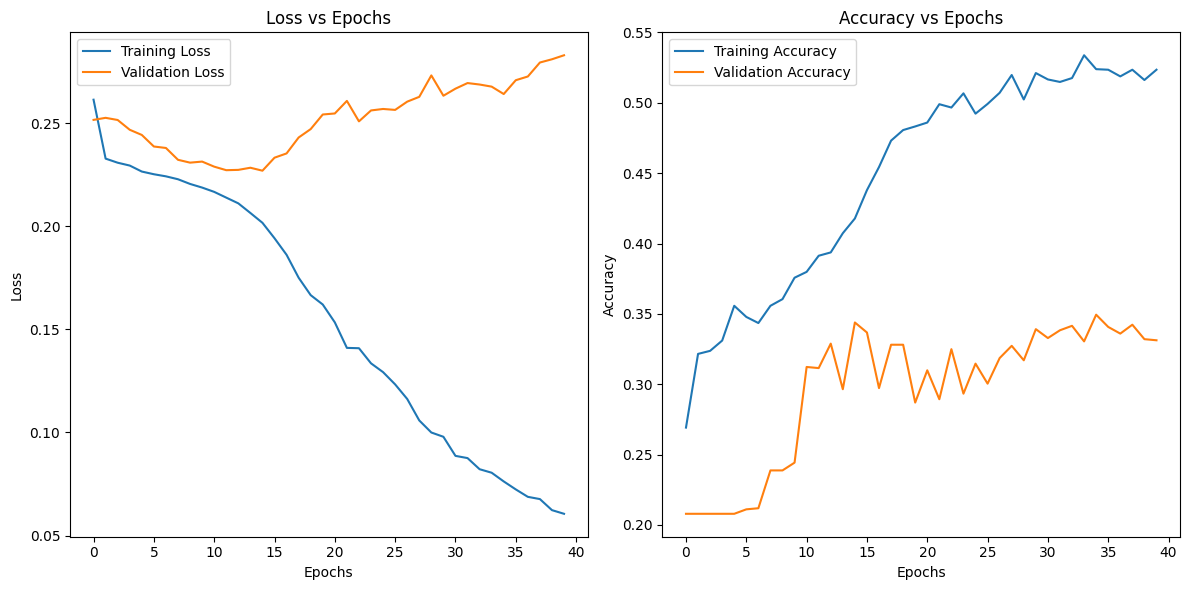

In [ ]:
# CodeGrade Tag Ex4a-i

import matplotlib.pyplot as plt

# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Plotting the loss for training and validation sets
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the accuracy for training and validation sets
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

The plots reveal the trends in loss and accuracy over epochs for both training and validation sets. A gradual decrease in loss indicates effective learning, while an increase in accuracy reflects improved model performance. Discrepancies between training and validation curves could suggest overfitting if training accuracy continues to improve while validation accuracy stagnates or declines. Consistent trends across both sets indicate a well-generalized model. To optimize performance, ensure sufficient epochs and consider techniques like early stopping, dropout, or data augmentation if overfitting arises. Monitoring these metrics is crucial for balancing training and generalization.

* **Load the best weights from your model checkpoint, and create plots demonstrating the classification performance for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

### 4.b. LSTM Evaluation

* **Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the model performance.**

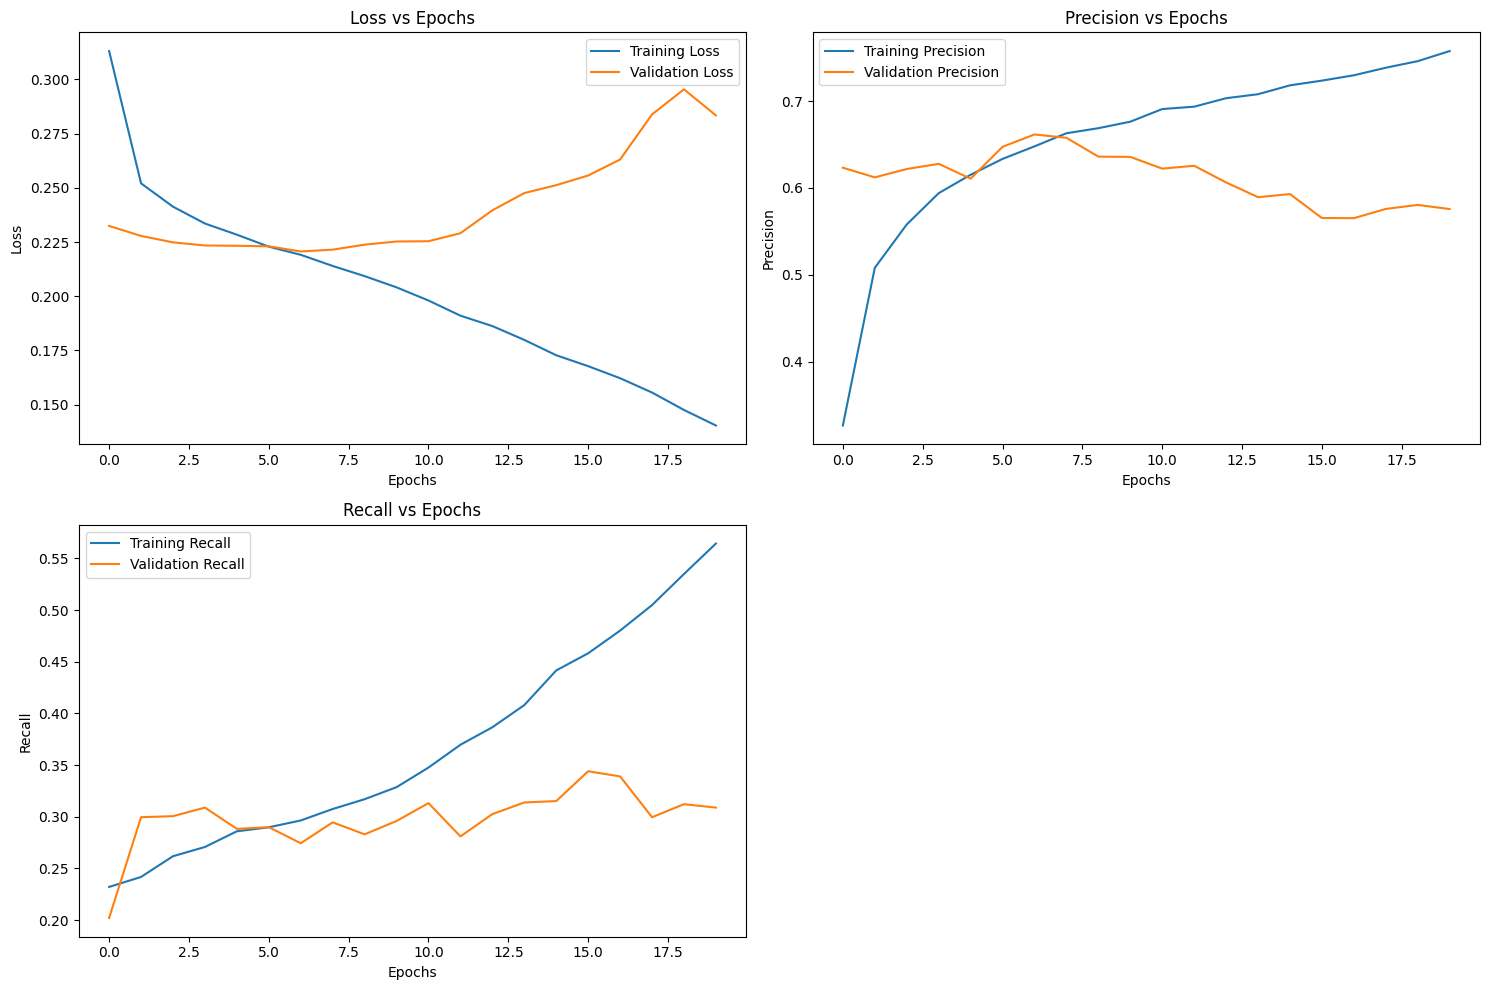

In [ ]:
# CodeGrade Tag Ex4b-i

import matplotlib.pyplot as plt

# Assuming 'lstm_history' contains the history of your model training
history = lstm_history.history

# Plotting the training and validation loss, precision, and recall
plt.figure(figsize=(15, 10))

# Plotting the loss for training and validation sets
plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation precision
plt.subplot(2, 2, 2)
plt.plot(history['precision_10'], label='Training Precision')
plt.plot(history['val_precision_10'], label='Validation Precision')
plt.title('Precision vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plotting the training and validation recall
plt.subplot(2, 2, 3)
plt.plot(history['recall_10'], label='Training Recall')
plt.plot(history['val_recall_10'], label='Validation Recall')
plt.title('Recall vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


The plots provide insights into the training and validation performance of the LSTM model. The loss plot shows how well the model is learning; a steady decline indicates good optimization. The precision and recall plots reveal how effectively the model predicts positive cases and captures relevant instances, respectively. Gaps between training and validation curves may indicate overfitting, especially if training precision and recall are high while validation performance lags. Consistent trends across all metrics suggest a balanced model. Address overfitting using techniques like regularization or early stopping, and ensure sufficient data for robust training and validation.

### 4.c. Produce examples for the report

* First, load the best weights from your checkpoints of both your models.

* Choose a few films from the dataset, plot their posters and print their overviews. Use these example films to demonstrate the classification performance of the CNN model on their posters and of the LSTM model on their overview.

* Be sure to demonstrate the results of the multi-label classification. Compare, for each example film, the top three most probable genres predicted by the CNN and the top three most probable genres predicted by the LSTM with the ground truth genres.

* Include these examples in your report, and critically evaluate on the performance of the model across the classes.

In [ ]:
# Load the best weights from the checkpoints
cnn_model.load_weights('/content/checkpoint_cnn.weights.h5')
lstm_model.load_weights('/content/checkpoint_lstm.weights.h5')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns

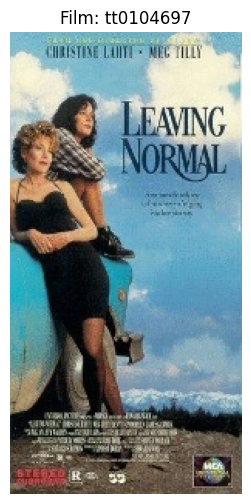

Overview for tt0104697:
For her entire life, twenty-seven year old Marianne Johnson has been on the move, the decisions which she's made as an adult which have been total failures, such as her second most recent ...



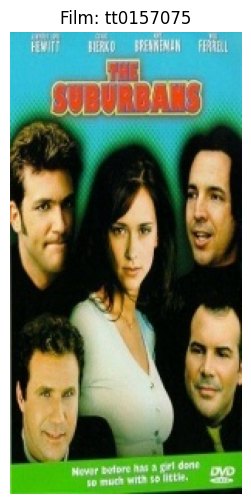

Overview for tt0157075:
A 1980s one-hit wonder band named "The Suburbans" reform for a special performance at one of the ex-member's wedding. At the wedding, a young record company talent scout happens to be in ...



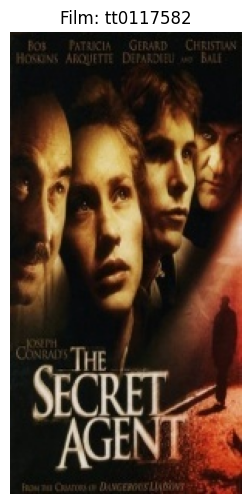

Overview for tt0117582:
London of the late 19th century is a haven for political exiles of all sorts - refugees, partisans, anarchists. Verloc has made his living spying for the Russian government, an agent ...



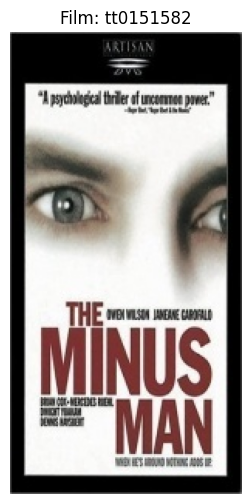

Overview for tt0151582:
A cold-blooded serial killer floats around the country and chooses his victims from people who complain about their lives and indicate a willingness to be killed. His murders are introduced...



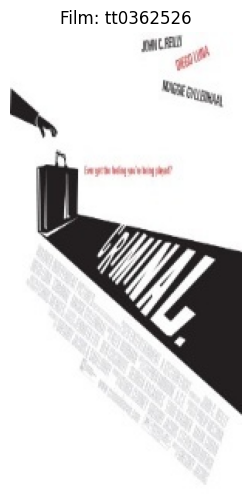

Overview for tt0362526:
Two con artists try to swindle a currency collector by selling him a counterfeit copy of an extremely rare currency bill.



In [ ]:
csv_loc = "/content/drive/MyDrive/Multimodal_IMDB_dataset/IMDB_overview_genres.csv"
dataset = pd.read_csv(csv_loc)

# Assuming dataset has columns 'Id', 'Genre', 'Overview', and the genres are in the form of multi-hot encoding
# Split the dataset into train and test
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
train = np.array(data_train.drop(['Id', 'Genre', 'Overview'], axis=1)).astype('float32')
test = np.array(data_test.drop(['Id', 'Genre', 'Overview'], axis=1)).astype('float32')

# List of genres
genres = np.array(data_train.drop(['Id', 'Genre', 'Overview'], axis=1).columns)

# List of overviews
overviews_train = np.array(data_train['Overview'])
overviews_test = np.array(data_test['Overview'])

# Get a few sample films (first 5 films in the train data as an example)
sample_films = data_train.head(5)

# Plot the posters and print the overviews for these films
for idx, film in sample_films.iterrows():
    img_path = f"/content/drive/MyDrive/Multimodal_IMDB_dataset/Images/{film['Id']}.jpg"  # Update this to the correct path for the images
    img = mpimg.imread(img_path)

    # Plot the poster
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Film: {film['Id']}")
    plt.show()

    # Print the overview
    print(f"Overview for {film['Id']}:\n{film['Overview']}\n")

## Conclusion
This project showcases the integration of CNNs and LSTMs for multimodal classification, leveraging the strengths of each modality. The comparative analysis of model performances provides valuable insights into their capabilities and limitations. Future improvements could include integrating multimodal inputs for joint classification and exploring transfer learning to enhance performance with limited data. The project underscores the significance of multimodal approaches in modern machine learning applications.
